# Muti-task Rodent TBI segmentation with Domain Adaptation
### Skull-stripping and ROI Segmentation

# Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#lib)
2. [Problem Definition](#problem)
3. [Data Description](#data)
4. [Configuration](#conf)
5. [Data Visualization](#visual)
6. [Evaluation Metrics](#metrics)  
7. [Data Loader](#load)
8. [Model](#model)
9. [Results](#results)
10. [Evaluation](#eval)

# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [1]:
import numpy as np
import os
import importlib
import pandas as pd
import time

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.model_selection import train_test_split

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

# fix random seed for reproducibility
seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)


Num GPUs Available:  1
2.10.0


# 2. Problem definiton<a class='anchor' id='problem'></a> [↑](#top)
Problem: Skull-stripping and ROI semantic segmentation<br>
Each pixel in the image has to be assigned one of the following labels: <br>
- Background (label 0)
- Lesion (red, label 1)
- CC contra (green, label 2)
- CC ipsi (dark blue, label 12)
- Ventricle contra (blue, label 3)
- Ventricle ipsi (light green, label 13)
- Hippo contra (cyan, label 5)
- Hippo ipsi (light brown, label 15)
- Cortex contra (pink, label 6)
- Cortex ispi (light blue, label 16)
- Third Ventricle (purple, label 21)

# 3. Image data descriptions <a class='anchor' id='data'></a> [↑](#top)

All multimodal scans are available as  NIfTI files (.nii.gz), a commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1w (Flash)**
2. **T2w (Rare)**

Data were acquired directly in this institute.
All the imaging datasets have been segmented manually.

# 4. Configuration <a class='anchor' id='conf'></a> [↑](#top)

In [2]:
config ={
    'dataset_path': '..\dataset_roi_cot',
    'input_shape': (80, 80, 80),
    'target_resolution': (0.1,0.1,0.1),
    'labels': [0,1,2,3,5,6,12,13,15,16,21],
    'num_classes': 11,
    'in_channels': 1,
    'batch_size': 8,
    'epochs': 300,
    'lr': 1e-3,
    'model_name': "mice_da_unet" + "_ep" + str(500) + time.strftime("_%d-%m-%Y_%H-%M"),
    'validation_split': 0.2,
    'test_split': 0.1,
    'sampling_rate': 3,
}

# 5. Data Visualization <a class='anchor' id='visual'></a> [↑](#top)

..\dataset_roi_cot\TBI-t2w-c52-4\TBI_fm_19_50\Anat


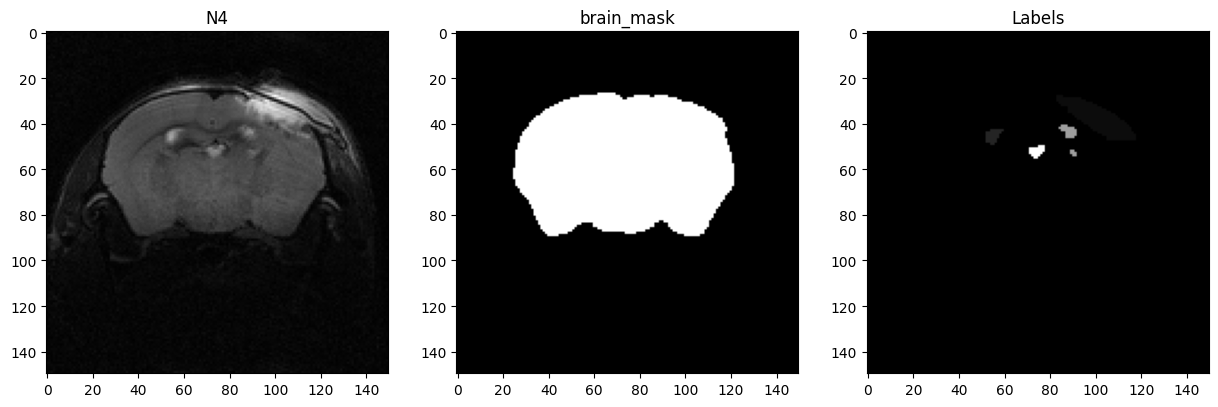

In [3]:
import utils.visualization
importlib.reload(utils.visualization)
from utils.visualization import *
from utils.loader import load_data

# Modalities
modalities = ['N4', 'brain_mask', 'Labels']

# Rodent scan
scan_type = 'TBI-t2w-c52-4'
scan_id = 'TBI_fm_19_50'
scan_folder = os.path.join(config['dataset_path'], scan_type, scan_id, 'Anat')
print(scan_folder)

# Load data
img, data, file_paths = load_data(scan_folder, scan_id, modalities)

# Plot data
plot_data(data)

In [4]:
# Check unique values in the lesion mask
print(f"Unique values in the lesion mask: {np.unique(data['brain_mask'])}")

Unique values in the lesion mask: [0. 1.]


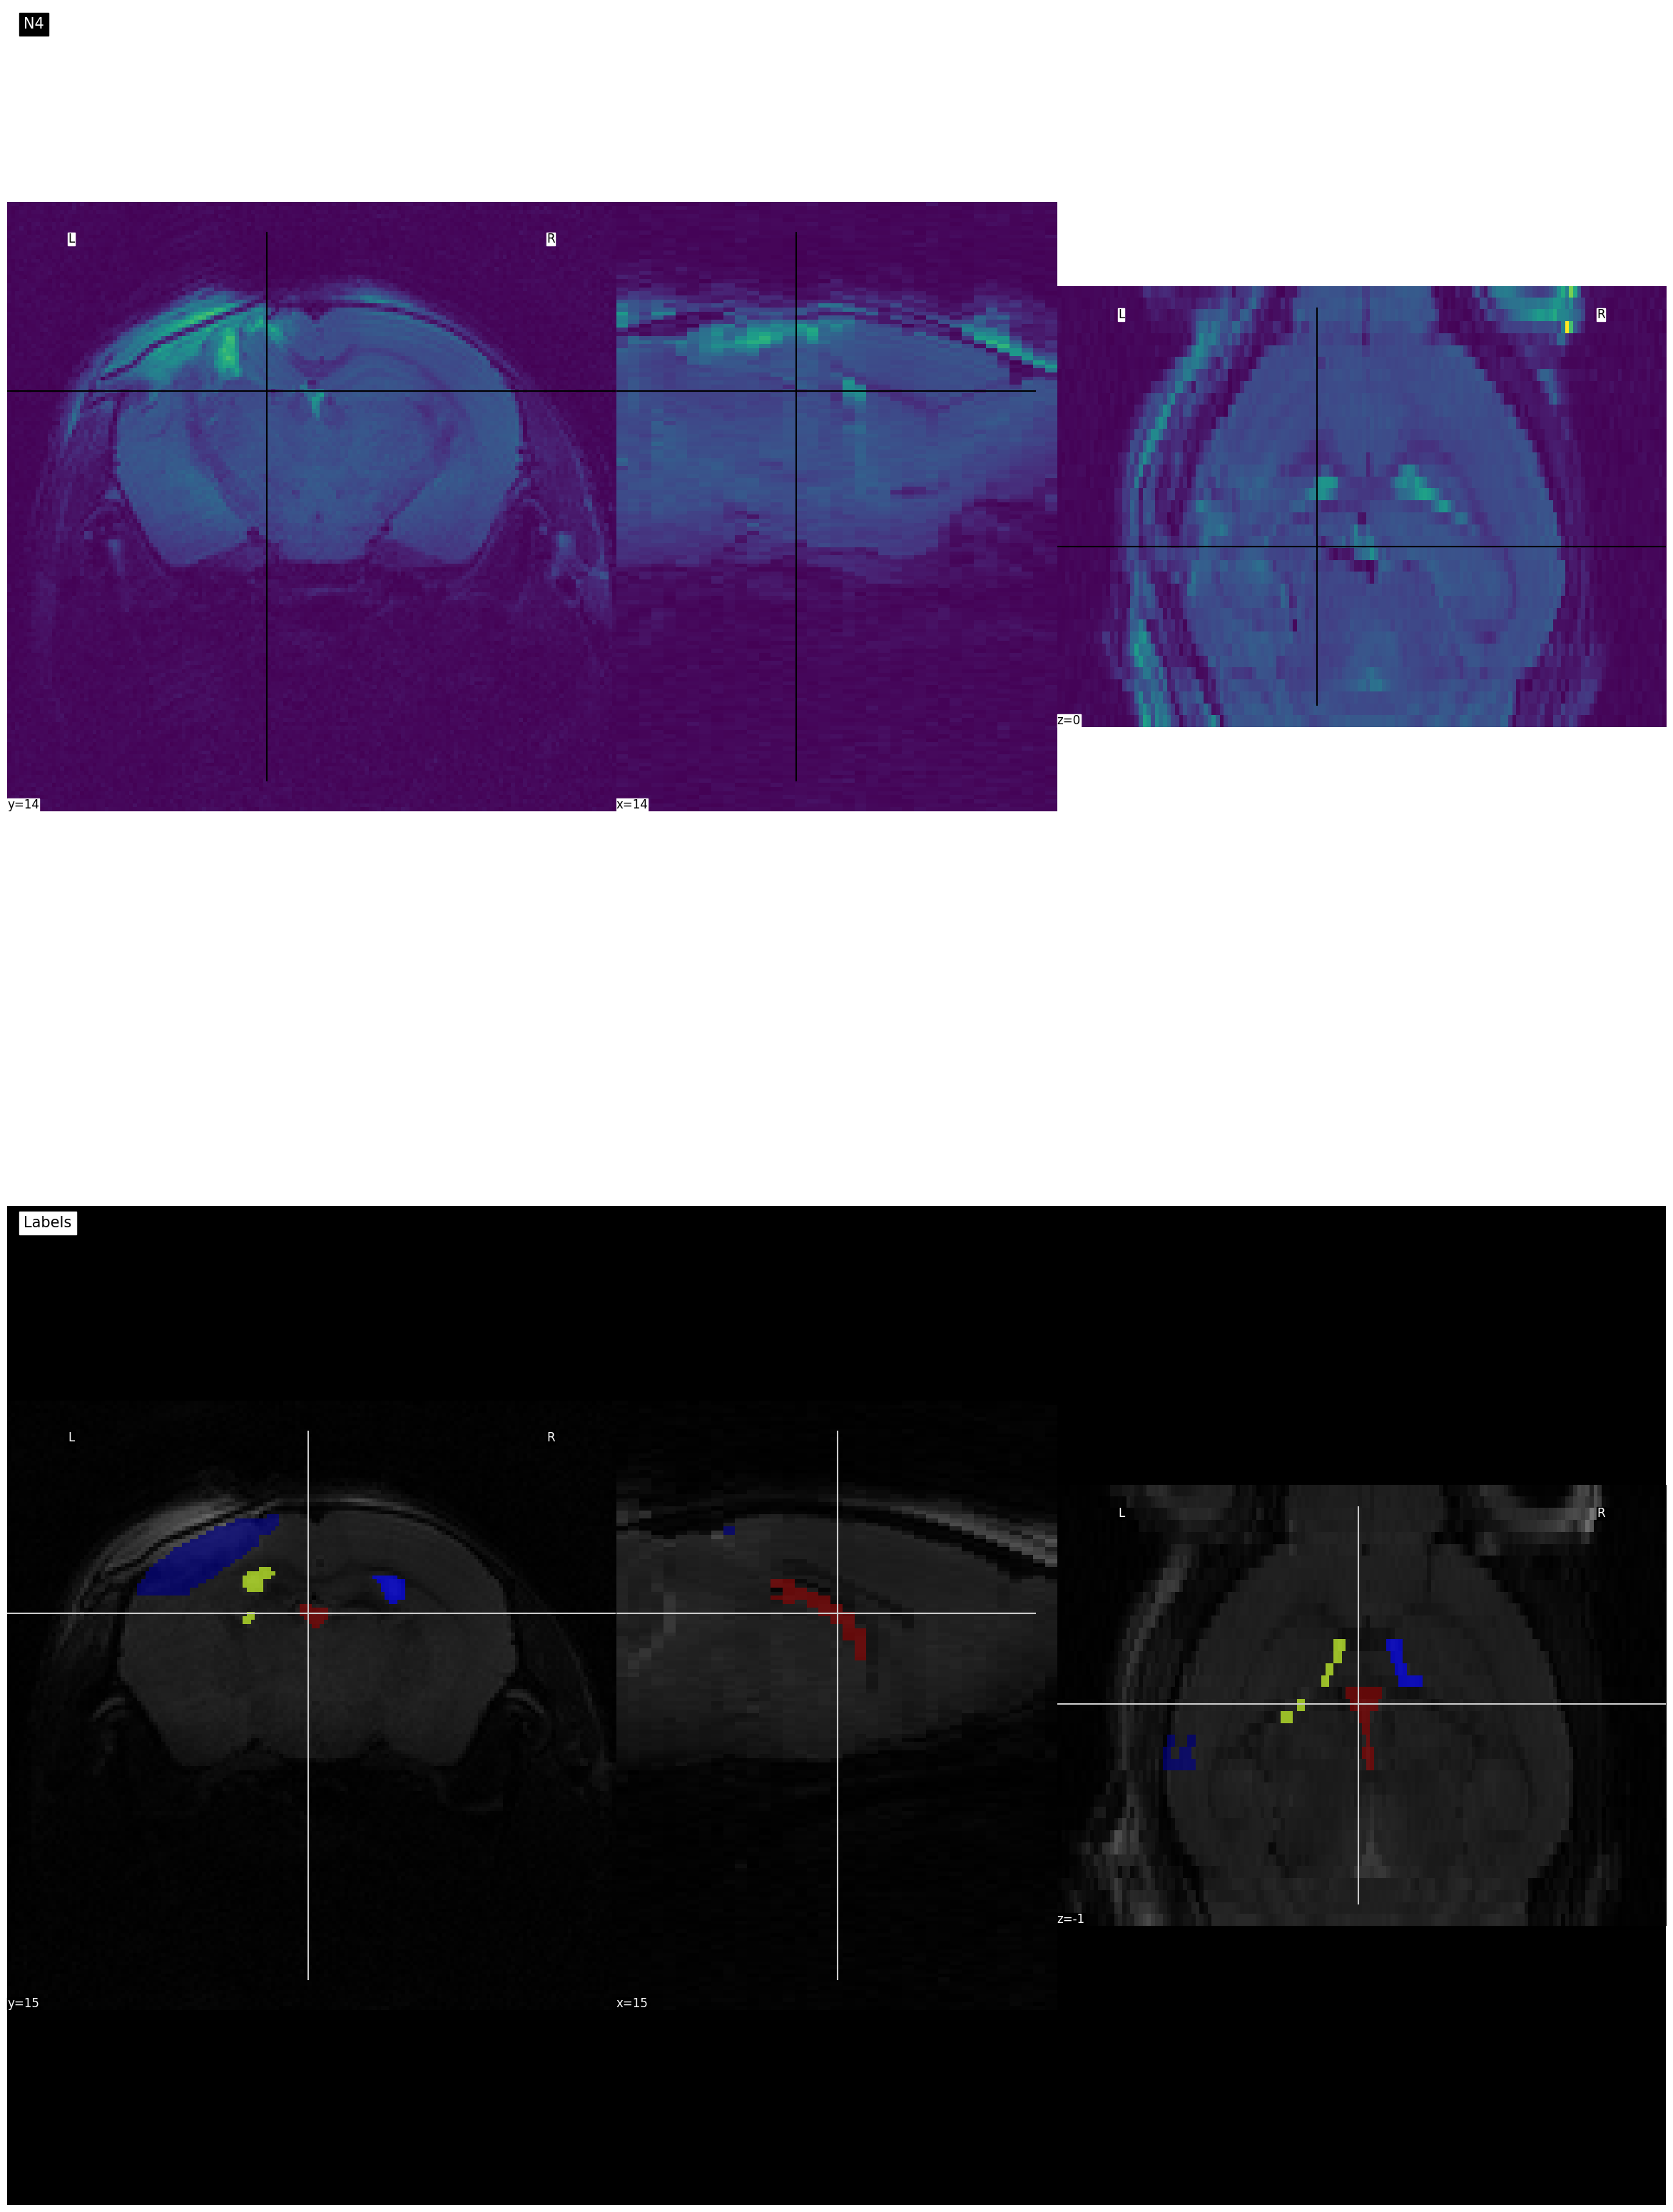

In [5]:
niimg = nl.image.load_img(file_paths['N4'])
nimask = nl.image.load_img(file_paths['Labels'])
fig, axes = plt.subplots(nrows=2, figsize=(30, 40))

# Plot 'niimg' as an anatomical image on the first subplot
nlplt.plot_img(niimg, title='N4', axes=axes[0])
# Plot 'nimask' as a region of interest (ROI) on top of 'niimg' on the fourth subplot
nlplt.plot_roi(nimask, title='Labels', bg_img=niimg, axes=axes[1], cmap='jet')
plt.show()

In [9]:
# Print matrix shape
print(f"Matrix shape: {data['N4'].shape}")

Matrix shape: (150, 150, 37)


# 6. Evaluation Metrics <a class='anchor' id='metrics'></a> [↑](#top)

In [6]:
from evaluation.metrics import *
from evaluation.losses import *

metrics = [accuracy_coefficient(domain_adaptation=True), precision_coefficient(domain_adaptation=True), 
           sensitivity_coefficient(domain_adaptation=True), specificity_coefficient(domain_adaptation=True), 
           dice_coefficient(domain_adaptation=True), iou_coefficient(domain_adaptation=True), volume_similarity_coefficient(domain_adaptation=True)]

for i in range(config['num_classes']):
    metrics.append(dice_coefficient(class_index=i, exclude_background=False, domain_adaptation=True))

# 7. Data Loader <a class='anchor' id='load'></a> [↑](#top)
Loading all data into memory is not a good idea since the data are too big to fit in.<br>
So we will create a DataGenerators class to load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [7]:
import utils.loader
importlib.reload(utils.loader)
from utils.loader import RodentDatasets

# Main Dataset
dataset = RodentDatasets(labels=config['labels'])

# Add all datasets
dataset.add_dataset(config['dataset_path'], 'TBI-T1w-c52-10', 'Anat')
dataset.add_dataset(config['dataset_path'], 'TBI-T2w-c52-10', 'Anat')
dataset.add_dataset(config['dataset_path'], 'TBI-T1w-c52-4', 'Anat', unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'TBI-T1w-cd1-4', 'Anat', unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'TBI-T2w-c52-4', 'Anat', unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52a-10', 'Anat', sham=True)
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52b-10', 'Anat', sham=True)
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52c-10', 'Anat', sham=True)
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-c52d-4', 'Anat', sham=True, unavailable_labels=[0,2,5,6,12,15,16])
dataset.add_dataset(config['dataset_path'], 'SHAM-T1w-cd1-4', 'Anat', sham=True, unavailable_labels=[0,2,5,6,12,15,16])

train_and_test_ids = dataset.get_subjects_list()
print('Size of the dataset: ', len(train_and_test_ids))

# Splitting
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=config['validation_split']) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=config['test_split'])

Added 4 subjects from TBI-T1w-c52-10
Added 5 subjects from TBI-T2w-c52-10
Added 67 subjects from TBI-T1w-c52-4
Added 15 subjects from TBI-T1w-cd1-4
Added 21 subjects from TBI-T2w-c52-4
Added 9 subjects from SHAM-T1w-c52a-10
Added 21 subjects from SHAM-T1w-c52b-10
Added 49 subjects from SHAM-T1w-c52c-10
Added 2 subjects from SHAM-T1w-c52d-4
Added 5 subjects from SHAM-T1w-cd1-4
Size of the dataset:  198


In [8]:
# Sample multiple times the same subject to increase the number of samples and variability exploiting on-the-fly data augmentation
train_ids = train_ids * config['sampling_rate']
val_ids = val_ids * config['sampling_rate']
test_ids = test_ids * config['sampling_rate']
print('New size of the dataset: ', len(train_ids) + len(val_ids) + len(test_ids))

Train size:  142
Validation size:  40
Test size:  16
New size of the dataset:  594


In [16]:
import importlib
import preprocessing.preprocessor
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, Resample, Reorient, Normalize, CorrectX10, MapLabels, RandomCropping, RandomAffine, GaussianBlur, Noise

# ref image for reorientation
ref_img = nib.load(os.path.join('../example', 'RARE', 'TBI_fm_19_49', 'Anat', 'TBI_fm_19_49_N4.nii.gz'))

augmented = Preprocessor([
    MapLabels(config['labels']),
    CorrectX10(),
    Reorient(ref_img),
    RandomAffine(rotation_range=[-5,5], scale_range=[0.95,1.05], probability=0.3),
    GaussianBlur([0,0.6], probability=0.3),
    Noise([0,0.05], probability=0.3),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    RandomCropping(config['input_shape'], mode='center', std=None),
])

preprocessor =  Preprocessor([
    MapLabels(config['labels']),
    CorrectX10(),
    Reorient(ref_img),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    RandomCropping(config['input_shape'], mode='center', std=None),
])

In [20]:
import importlib
import preprocessing.generator
importlib.reload(preprocessing.generator)
from preprocessing.generator import DomainAdaptationGenerator

# Datasets Initialization
training_generator = DomainAdaptationGenerator(train_ids, dataset, batch_size=config['batch_size'], preprocessor=augmented, config=config)
valid_generator = DomainAdaptationGenerator(val_ids, dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)
test_generator = DomainAdaptationGenerator(test_ids, dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)

print("Val IDs: ", val_ids)
print("Train IDs: ", train_ids)
print("Test IDs: ", test_ids)

Generator configuration:
- Dataset path: ..\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 11
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 11
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 11
- Shuffle: True

Val IDs:  [('TBI-T1w-cd1-4', 'TBI_PTE_fm_20_193'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_35'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_4'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_31'), ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1781'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_148_5M'), ('SHAM-T1w-c52d-4', 'TBI_AAV_PPIAKO_1763'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_129_5M'), ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_12'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_169_5M'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_128_5M'), ('TBI-T2w

## Sanity Check

Img shape:  (8, 80, 80, 80, 1)
Labels shape:  (8, 80, 80, 80, 11)
Brain mask shape: (8, 80, 80, 80, 1)
Sham shape:  (8, 1)
Max value in X:  11.132079727130117
Min value in X:  -1.1690175007795713
Unique values in Y:  [-1.  0.  1.]
Max value in Y:  1.0
Min value in Y:  -1.0
Is Sham?  yes
Unique values in Y:  [ 0  1  3  7 10]


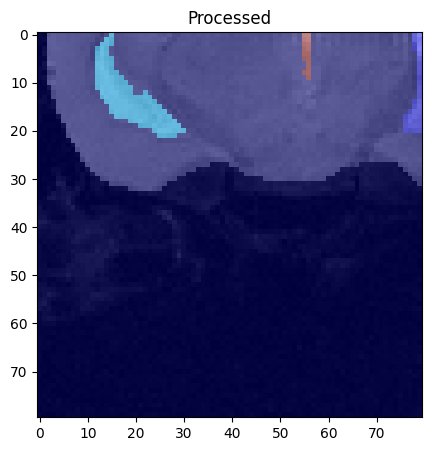

In [21]:
X,[Y,M,S]= training_generator.__getitem__(index=0) # Fetching the first batch  (X, [Seg, Sham, Ignore])

print('Img shape: ', X.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, IN_CHANNELS) 
print('Labels shape: ', Y.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, NUM_CLASSES)
print('Brain mask shape:', M.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, 1)
print('Sham shape: ',S.shape) # Should be equal to (BATCH_SIZE, 1)

# print max and min values in X
print("Max value in X: ", np.max(X))
print("Min value in X: ", np.min(X))

# Check if Y is one-hot encoded and has 4 different channels with label 1
print("Unique values in Y: ", np.unique(Y))
# print max and min values in Y
print("Max value in Y: ", np.max(Y))
print("Min value in Y: ", np.min(Y))

sample=3
layer=config['input_shape'][2]//2

yhat=Y[sample]
yhat[yhat==-1]=0 # Convert all -1 to 0
yhat = np.argmax(yhat, axis=-1)

# Print 'yes' if sham
print("Is Sham? ", 'yes' if S[sample] else 'no')
print("Unique values in Y: ", np.unique(yhat))
plt.figure(figsize=(15, 5))
plt.imshow(np.rot90(X[sample,:,:,layer,0], k=-1),cmap='gray')
plt.imshow(np.rot90(yhat[:,:,layer], k=-1), cmap='jet', alpha=0.6)
plt.imshow(np.rot90(M[sample,:,:,layer,0], k=-1), cmap='gray', alpha=0.2)
plt.title("Processed")

plt.show()

## Show Data Split Distribution

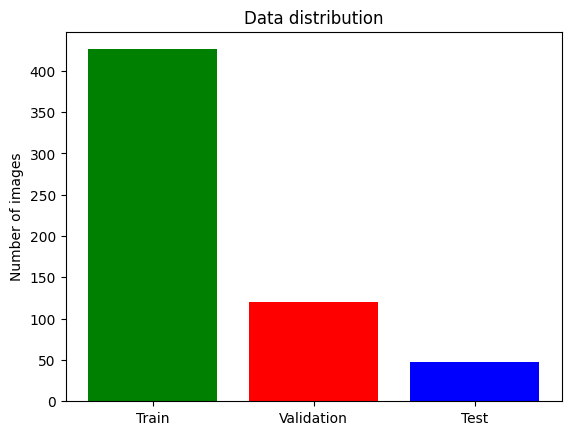

In [22]:
# Show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Validation", "Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red','blue'])

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

# 8. Model | 3D U-Net <a class='anchor' id='model'></a> [↑](#top)

In [27]:
from models.networks import *

# Example usage:
filters = [16, 32, 64, 128, 256]
model = mt_r_net_3d((None,None,None), config['in_channels'], config['num_classes'], filters, attention=True, residual=True, with_classifier=True)

## Overview

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_94 (Conv3D)             (None, None, None,   448         ['input_4[0][0]']                
                                None, 16)                                                         
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   64         ['conv3d_94[0][0]']              
 ormalization)                  None, 16)                                                   

## Callbacks

In [29]:
import datetime
csv_logger = CSVLogger('../results/'+config['model_name']+'/training.log', separator=',', append=False)
log_dir = "../results/"+config['model_name']+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "../results/"+config['model_name']+"/checkpoint/"

callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
        csv_logger
    ]

## Training

In [17]:
steps = len(train_ids) // config['batch_size']
val_steps = len(val_ids) // config['batch_size']

roi_loss = diceCELoss(smooth=1e-5, batch_wise=True, gamma=0.8, domain_adaptation=True)
skullstrip_loss = diceBCELoss(alpha=0.6, smooth=1e-5, batch_wise=True)
sham_loss = weightedBinaryCrossentropy()

losses = {
    'regions': roi_loss,
    'classifier': sham_loss,
    'brain_mask': skullstrip_loss
}

loss_weights = {
    'regions': 1,
    'classifier': 1,
    'brain_mask': 1,
}

metrics = {
    'regions': metrics,
    'classifier': 'accuracy',
    'brain_mask': dice_coefficient(class_index=0, exclude_background=False)
}

model.compile(loss=losses, optimizer=tf.keras.optimizers.Nadam(learning_rate=config['lr']), metrics = metrics, loss_weights=loss_weights)
history =  model.fit(training_generator,epochs=config['epochs'], steps_per_epoch=steps, callbacks= callbacks, validation_data=valid_generator, validation_steps=val_steps)

Epoch 1/300
53/53 [==============================] - ETA: 0s - loss: 0.8169 - regions_loss: 0.1979 - brain_mask_loss: 0.1517 - classifier_loss: 0.3846 - regions_mean_accuracy: 0.9886 - regions_mean_precision: 0.1191 - regions_mean_sensitivity: 0.1038 - regions_mean_specificity: 0.9936 - regions_mean_dice: 0.0938 - regions_mean_iou: 0.0610 - regions_mean_volume_similarity: 0.3736 - regions_class_0_dice: 0.8995 - regions_class_1_dice: 0.1846 - regions_class_2_dice: 0.0234 - regions_class_3_dice: 3.8722e-04 - regions_class_4_dice: 0.0228 - regions_class_5_dice: 0.3234 - regions_class_6_dice: 0.0213 - regions_class_7_dice: 0.0061 - regions_class_8_dice: 0.0783 - regions_class_9_dice: 0.2504 - regions_class_10_dice: 0.0277 - brain_mask_class_0_dice: 0.8612 - classifier_accuracy: 0.6792

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 247s 4s/step - loss: 0.8169 - regions_loss: 0.1979 - brain_mask_loss: 0.1517 - classifier_loss: 0.3846 - regions_mean_accuracy: 0.9886 - regions_mean_precision: 0.1191 - regions_mean_sensitivity: 0.1038 - regions_mean_specificity: 0.9936 - regions_mean_dice: 0.0938 - regions_mean_iou: 0.0610 - regions_mean_volume_similarity: 0.3736 - regions_class_0_dice: 0.8995 - regions_class_1_dice: 0.1846 - regions_class_2_dice: 0.0234 - regions_class_3_dice: 3.8722e-04 - regions_class_4_dice: 0.0228 - regions_class_5_dice: 0.3234 - regions_class_6_dice: 0.0213 - regions_class_7_dice: 0.0061 - regions_class_8_dice: 0.0783 - regions_class_9_dice: 0.2504 - regions_class_10_dice: 0.0277 - brain_mask_class_0_dice: 0.8612 - classifier_accuracy: 0.6792 - val_loss: 4.5035 - val_regions_loss: 0.2578 - val_brain_mask_loss: 1.3732 - val_classifier_loss: 2.7899 - val_regions_mean_accuracy: 0.9854 - val_regions_mean_precision: 0.0168 - val_regions_mean_sensitivity: 0.01

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 174s 3s/step - loss: 0.5021 - regions_loss: 0.1528 - brain_mask_loss: 0.0734 - classifier_loss: 0.1935 - regions_mean_accuracy: 0.9934 - regions_mean_precision: 0.3536 - regions_mean_sensitivity: 0.2661 - regions_mean_specificity: 0.9972 - regions_mean_dice: 0.2763 - regions_mean_iou: 0.1864 - regions_mean_volume_similarity: 0.6028 - regions_class_0_dice: 0.9575 - regions_class_1_dice: 0.3944 - regions_class_2_dice: 0.3219 - regions_class_3_dice: 0.0360 - regions_class_4_dice: 0.2141 - regions_class_5_dice: 0.6315 - regions_class_6_dice: 0.2976 - regions_class_7_dice: 0.0626 - regions_class_8_dice: 0.1017 - regions_class_9_dice: 0.5892 - regions_class_10_dice: 0.1146 - brain_mask_class_0_dice: 0.9353 - classifier_accuracy: 0.8349 - val_loss: 3.7566 - val_regions_loss: 0.2736 - val_brain_mask_loss: 0.6110 - val_classifier_loss: 2.7899 - val_regions_mean_accuracy: 0.9777 - val_regions_mean_precision: 0.0209 - val_regions_mean_sensitivity: 0.0841 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 174s 3s/step - loss: 0.4196 - regions_loss: 0.1277 - brain_mask_loss: 0.0560 - classifier_loss: 0.1540 - regions_mean_accuracy: 0.9949 - regions_mean_precision: 0.4848 - regions_mean_sensitivity: 0.4028 - regions_mean_specificity: 0.9978 - regions_mean_dice: 0.4051 - regions_mean_iou: 0.2771 - regions_mean_volume_similarity: 0.7130 - regions_class_0_dice: 0.9669 - regions_class_1_dice: 0.5219 - regions_class_2_dice: 0.4792 - regions_class_3_dice: 0.2739 - regions_class_4_dice: 0.3763 - regions_class_5_dice: 0.6367 - regions_class_6_dice: 0.3845 - regions_class_7_dice: 0.2008 - regions_class_8_dice: 0.3306 - regions_class_9_dice: 0.6101 - regions_class_10_dice: 0.2373 - brain_mask_class_0_dice: 0.9520 - classifier_accuracy: 0.8679 - val_loss: 1.7702 - val_regions_loss: 0.1542 - val_brain_mask_loss: 0.1288 - val_classifier_loss: 1.4057 - val_regions_mean_accuracy: 0.9942 - val_regions_mean_precision: 0.4679 - val_regions_mean_sensitivity: 0.2290 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 174s 3s/step - loss: 0.3246 - regions_loss: 0.0859 - brain_mask_loss: 0.0384 - classifier_loss: 0.1192 - regions_mean_accuracy: 0.9961 - regions_mean_precision: 0.6703 - regions_mean_sensitivity: 0.5966 - regions_mean_specificity: 0.9983 - regions_mean_dice: 0.6252 - regions_mean_iou: 0.4697 - regions_mean_volume_similarity: 0.8555 - regions_class_0_dice: 0.9728 - regions_class_1_dice: 0.6340 - regions_class_2_dice: 0.6635 - regions_class_3_dice: 0.6114 - regions_class_4_dice: 0.6145 - regions_class_5_dice: 0.7509 - regions_class_6_dice: 0.5984 - regions_class_7_dice: 0.5633 - regions_class_8_dice: 0.6239 - regions_class_9_dice: 0.7297 - regions_class_10_dice: 0.4626 - brain_mask_class_0_dice: 0.9678 - classifier_accuracy: 0.8892 - val_loss: 0.3613 - val_regions_loss: 0.1010 - val_brain_mask_loss: 0.0570 - val_classifier_loss: 0.1226 - val_regions_mean_accuracy: 0.9957 - val_regions_mean_precision: 0.6461 - val_regions_mean_sensitivity: 0.4960 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 176s 3s/step - loss: 0.2822 - regions_loss: 0.0772 - brain_mask_loss: 0.0386 - classifier_loss: 0.0860 - regions_mean_accuracy: 0.9968 - regions_mean_precision: 0.6951 - regions_mean_sensitivity: 0.6324 - regions_mean_specificity: 0.9986 - regions_mean_dice: 0.6651 - regions_mean_iou: 0.5162 - regions_mean_volume_similarity: 0.8567 - regions_class_0_dice: 0.9789 - regions_class_1_dice: 0.6157 - regions_class_2_dice: 0.7176 - regions_class_3_dice: 0.6698 - regions_class_4_dice: 0.6481 - regions_class_5_dice: 0.7748 - regions_class_6_dice: 0.6724 - regions_class_7_dice: 0.6367 - regions_class_8_dice: 0.6483 - regions_class_9_dice: 0.7631 - regions_class_10_dice: 0.5050 - brain_mask_class_0_dice: 0.9662 - classifier_accuracy: 0.9410 - val_loss: 0.2337 - val_regions_loss: 0.0862 - val_brain_mask_loss: 0.0376 - val_classifier_loss: 0.0296 - val_regions_mean_accuracy: 0.9969 - val_regions_mean_precision: 0.7131 - val_regions_mean_sensitivity: 0.5552 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 172s 3s/step - loss: 0.2484 - regions_loss: 0.0584 - brain_mask_loss: 0.0271 - classifier_loss: 0.0835 - regions_mean_accuracy: 0.9972 - regions_mean_precision: 0.7460 - regions_mean_sensitivity: 0.7006 - regions_mean_specificity: 0.9987 - regions_mean_dice: 0.7442 - regions_mean_iou: 0.6040 - regions_mean_volume_similarity: 0.9063 - regions_class_0_dice: 0.9820 - regions_class_1_dice: 0.7100 - regions_class_2_dice: 0.7671 - regions_class_3_dice: 0.7594 - regions_class_4_dice: 0.7586 - regions_class_5_dice: 0.8101 - regions_class_6_dice: 0.7457 - regions_class_7_dice: 0.7134 - regions_class_8_dice: 0.7659 - regions_class_9_dice: 0.7827 - regions_class_10_dice: 0.6297 - brain_mask_class_0_dice: 0.9771 - classifier_accuracy: 0.9387 - val_loss: 0.2163 - val_regions_loss: 0.0677 - val_brain_mask_loss: 0.0232 - val_classifier_loss: 0.0464 - val_regions_mean_accuracy: 0.9965 - val_regions_mean_precision: 0.8013 - val_regions_mean_sensitivity: 0.6548 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 169s 3s/step - loss: 0.2077 - regions_loss: 0.0449 - brain_mask_loss: 0.0229 - classifier_loss: 0.0638 - regions_mean_accuracy: 0.9978 - regions_mean_precision: 0.8197 - regions_mean_sensitivity: 0.7885 - regions_mean_specificity: 0.9990 - regions_mean_dice: 0.7978 - regions_mean_iou: 0.6732 - regions_mean_volume_similarity: 0.9243 - regions_class_0_dice: 0.9843 - regions_class_1_dice: 0.6970 - regions_class_2_dice: 0.8086 - regions_class_3_dice: 0.8138 - regions_class_4_dice: 0.8204 - regions_class_5_dice: 0.8661 - regions_class_6_dice: 0.7908 - regions_class_7_dice: 0.7916 - regions_class_8_dice: 0.8308 - regions_class_9_dice: 0.8548 - regions_class_10_dice: 0.7043 - brain_mask_class_0_dice: 0.9804 - classifier_accuracy: 0.9528 - val_loss: 0.1918 - val_regions_loss: 0.0541 - val_brain_mask_loss: 0.0223 - val_classifier_loss: 0.0396 - val_regions_mean_accuracy: 0.9982 - val_regions_mean_precision: 0.7515 - val_regions_mean_sensitivity: 0.7399 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 175s 3s/step - loss: 0.1842 - regions_loss: 0.0436 - brain_mask_loss: 0.0220 - classifier_loss: 0.0458 - regions_mean_accuracy: 0.9982 - regions_mean_precision: 0.7900 - regions_mean_sensitivity: 0.7691 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8127 - regions_mean_iou: 0.6983 - regions_mean_volume_similarity: 0.9300 - regions_class_0_dice: 0.9898 - regions_class_1_dice: 0.7698 - regions_class_2_dice: 0.8208 - regions_class_3_dice: 0.8277 - regions_class_4_dice: 0.8285 - regions_class_5_dice: 0.8641 - regions_class_6_dice: 0.8006 - regions_class_7_dice: 0.7575 - regions_class_8_dice: 0.8240 - regions_class_9_dice: 0.8837 - regions_class_10_dice: 0.7504 - brain_mask_class_0_dice: 0.9808 - classifier_accuracy: 0.9717 - val_loss: 0.1489 - val_regions_loss: 0.0412 - val_brain_mask_loss: 0.0217 - val_classifier_loss: 0.0135 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.8386 - val_regions_mean_sensitivity: 0.7914 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 176s 3s/step - loss: 0.1504 - regions_loss: 0.0292 - brain_mask_loss: 0.0196 - classifier_loss: 0.0354 - regions_mean_accuracy: 0.9984 - regions_mean_precision: 0.8550 - regions_mean_sensitivity: 0.8427 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8576 - regions_mean_iou: 0.7574 - regions_mean_volume_similarity: 0.9583 - regions_class_0_dice: 0.9892 - regions_class_1_dice: 0.7996 - regions_class_2_dice: 0.8587 - regions_class_3_dice: 0.8609 - regions_class_4_dice: 0.8935 - regions_class_5_dice: 0.9122 - regions_class_6_dice: 0.8494 - regions_class_7_dice: 0.8260 - regions_class_8_dice: 0.8901 - regions_class_9_dice: 0.9039 - regions_class_10_dice: 0.7817 - brain_mask_class_0_dice: 0.9834 - classifier_accuracy: 0.9788 - val_loss: 0.1210 - val_regions_loss: 0.0222 - val_brain_mask_loss: 0.0180 - val_classifier_loss: 0.0151 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.8364 - val_regions_mean_sensitivity: 0.8116 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 176s 3s/step - loss: 0.1329 - regions_loss: 0.0366 - brain_mask_loss: 0.0175 - classifier_loss: 0.0224 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.8276 - regions_mean_sensitivity: 0.8246 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8547 - regions_mean_iou: 0.7648 - regions_mean_volume_similarity: 0.9456 - regions_class_0_dice: 0.9925 - regions_class_1_dice: 0.8354 - regions_class_2_dice: 0.8404 - regions_class_3_dice: 0.8733 - regions_class_4_dice: 0.8654 - regions_class_5_dice: 0.9171 - regions_class_6_dice: 0.8236 - regions_class_7_dice: 0.8302 - regions_class_8_dice: 0.8462 - regions_class_9_dice: 0.9118 - regions_class_10_dice: 0.8037 - brain_mask_class_0_dice: 0.9847 - classifier_accuracy: 0.9811 - val_loss: 0.1202 - val_regions_loss: 0.0230 - val_brain_mask_loss: 0.0174 - val_classifier_loss: 0.0236 - val_regions_mean_accuracy: 0.9987 - val_regions_mean_precision: 0.8227 - val_regions_mean_sensitivity: 0.8093 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 176s 3s/step - loss: 0.1152 - regions_loss: 0.0265 - brain_mask_loss: 0.0161 - classifier_loss: 0.0210 - regions_mean_accuracy: 0.9989 - regions_mean_precision: 0.8769 - regions_mean_sensitivity: 0.8817 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8761 - regions_mean_iou: 0.7898 - regions_mean_volume_similarity: 0.9605 - regions_class_0_dice: 0.9924 - regions_class_1_dice: 0.8446 - regions_class_2_dice: 0.8714 - regions_class_3_dice: 0.8846 - regions_class_4_dice: 0.8927 - regions_class_5_dice: 0.9142 - regions_class_6_dice: 0.8732 - regions_class_7_dice: 0.8546 - regions_class_8_dice: 0.8978 - regions_class_9_dice: 0.9140 - regions_class_10_dice: 0.8136 - brain_mask_class_0_dice: 0.9859 - classifier_accuracy: 0.9811 - val_loss: 0.1148 - val_regions_loss: 0.0275 - val_brain_mask_loss: 0.0165 - val_classifier_loss: 0.0192 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.8859 - val_regions_mean_sensitivity: 0.8601 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 174s 3s/step - loss: 0.1100 - regions_loss: 0.0262 - brain_mask_loss: 0.0159 - classifier_loss: 0.0175 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8799 - regions_mean_sensitivity: 0.8806 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8821 - regions_mean_iou: 0.7945 - regions_mean_volume_similarity: 0.9706 - regions_class_0_dice: 0.9920 - regions_class_1_dice: 0.8692 - regions_class_2_dice: 0.8713 - regions_class_3_dice: 0.8829 - regions_class_4_dice: 0.9054 - regions_class_5_dice: 0.9191 - regions_class_6_dice: 0.8736 - regions_class_7_dice: 0.8487 - regions_class_8_dice: 0.9160 - regions_class_9_dice: 0.9217 - regions_class_10_dice: 0.8134 - brain_mask_class_0_dice: 0.9860 - classifier_accuracy: 0.9858 - val_loss: 0.1094 - val_regions_loss: 0.0284 - val_brain_mask_loss: 0.0176 - val_classifier_loss: 0.0132 - val_regions_mean_accuracy: 0.9990 - val_regions_mean_precision: 0.8717 - val_regions_mean_sensitivity: 0.8616 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 179s 3s/step - loss: 0.1002 - regions_loss: 0.0233 - brain_mask_loss: 0.0145 - classifier_loss: 0.0155 - regions_mean_accuracy: 0.9990 - regions_mean_precision: 0.8685 - regions_mean_sensitivity: 0.8666 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8908 - regions_mean_iou: 0.8091 - regions_mean_volume_similarity: 0.9746 - regions_class_0_dice: 0.9944 - regions_class_1_dice: 0.8825 - regions_class_2_dice: 0.8802 - regions_class_3_dice: 0.8887 - regions_class_4_dice: 0.9269 - regions_class_5_dice: 0.9301 - regions_class_6_dice: 0.8753 - regions_class_7_dice: 0.8554 - regions_class_8_dice: 0.9092 - regions_class_9_dice: 0.9210 - regions_class_10_dice: 0.8391 - brain_mask_class_0_dice: 0.9873 - classifier_accuracy: 0.9906 - val_loss: 0.1046 - val_regions_loss: 0.0334 - val_brain_mask_loss: 0.0160 - val_classifier_loss: 0.0085 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.8365 - val_regions_mean_sensitivity: 0.8440 -

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_29-06-2024_01-22/checkpoint\assets


53/53 [==============================] - 177s 3s/step - loss: 0.1214 - regions_loss: 0.0281 - brain_mask_loss: 0.0150 - classifier_loss: 0.0316 - regions_mean_accuracy: 0.9991 - regions_mean_precision: 0.8673 - regions_mean_sensitivity: 0.8638 - regions_mean_specificity: 0.9996 - regions_mean_dice: 0.8780 - regions_mean_iou: 0.7941 - regions_mean_volume_similarity: 0.9611 - regions_class_0_dice: 0.9952 - regions_class_1_dice: 0.8971 - regions_class_2_dice: 0.8708 - regions_class_3_dice: 0.8848 - regions_class_4_dice: 0.8725 - regions_class_5_dice: 0.9203 - regions_class_6_dice: 0.8648 - regions_class_7_dice: 0.8384 - regions_class_8_dice: 0.8812 - regions_class_9_dice: 0.9182 - regions_class_10_dice: 0.8318 - brain_mask_class_0_dice: 0.9862 - classifier_accuracy: 0.9717 - val_loss: 0.1041 - val_regions_loss: 0.0159 - val_brain_mask_loss: 0.0161 - val_classifier_loss: 0.0256 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.7652 - val_regions_mean_sensitivity: 0.7607 -

In [18]:
_history = history.history

# Load the best model
model.load_weights(checkpoint_path)

# Save the model
model.save("../results/"+config['model_name']+"/save_" + config['model_name'] + ".h5")

# 9. Results <a class='anchor' id='results'></a> [↑](#top)
## History

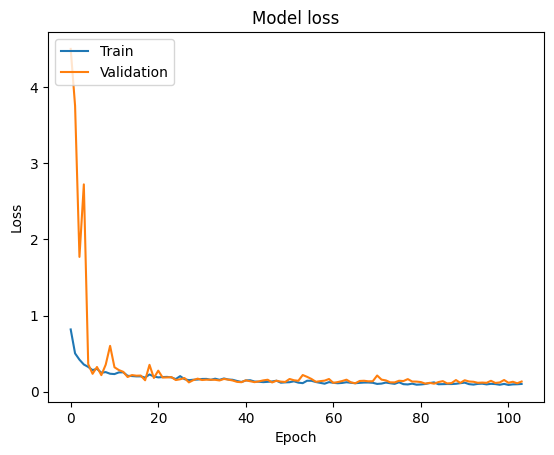

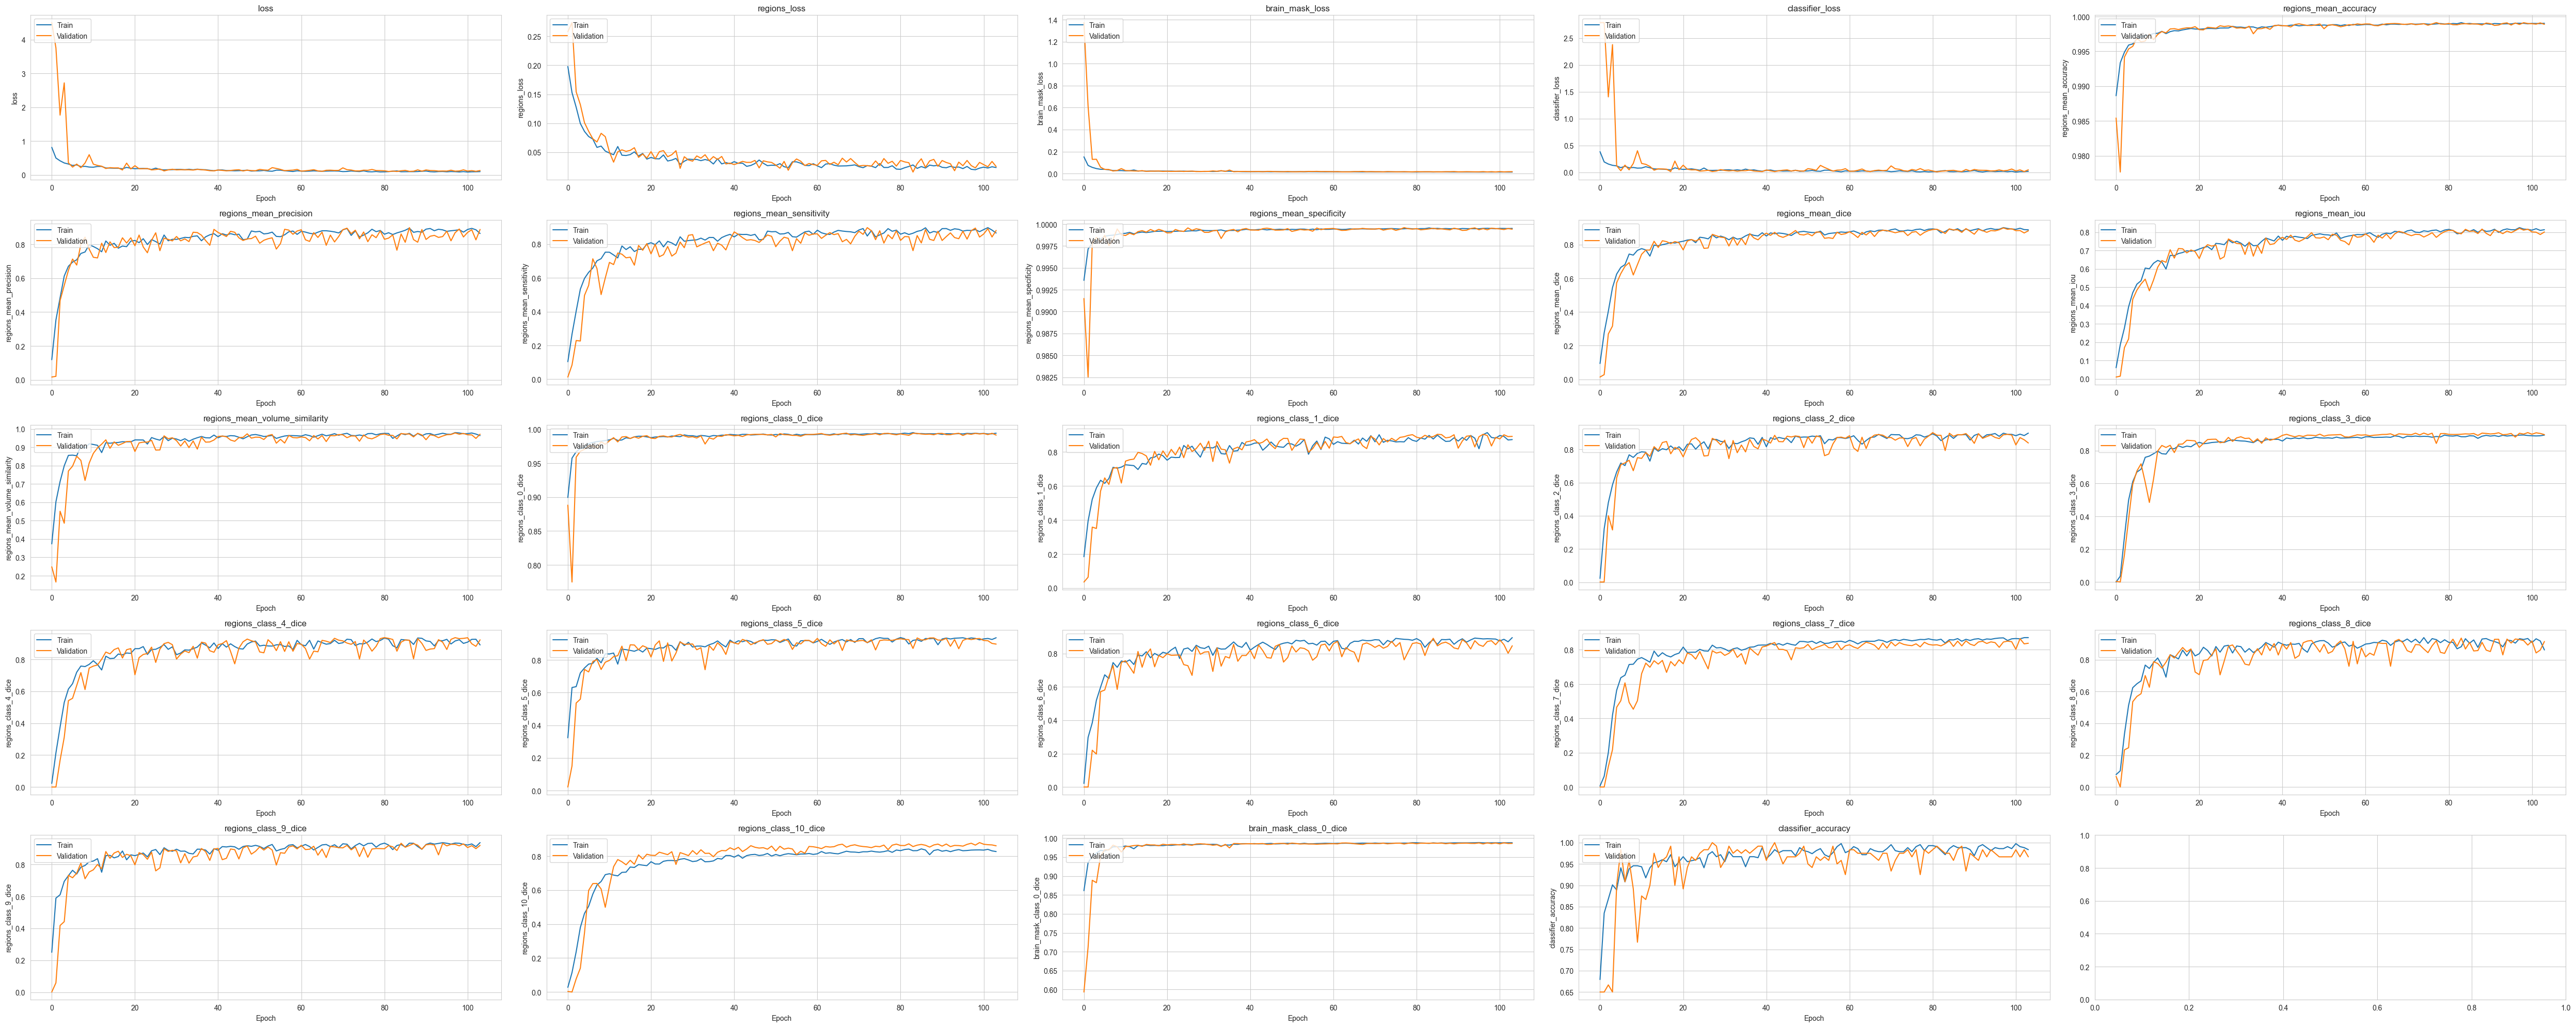

In [19]:
from utils.visualization import plot_history, plot_loss
plot_loss(_history, path='../results/'+config['model_name']+'/' + 'loss_history.png', log=False)
plot_history(_history, path='../results/'+config['model_name']+'/' + 'metrics_history.png', figsize=(50,20))

## Predictions

In [28]:
import utils.visualization  
importlib.reload(utils.visualization)
from utils.visualization import plot_domain_adaptation
# To plot the pre-processed data we can use our custom test generator with batch_size equal to 1
test_plot_generator = DomainAdaptationGenerator(ids=test_ids, loader=dataset, batch_size=1, preprocessor=preprocessor, config=config, shuffle=False)
for index in range(len(test_plot_generator))[:15]:
    plot_domain_adaptation(test_ids, index, test_plot_generator, model)

Generator configuration:
- Dataset path: ..\dataset_roi_cot
- Dimensions: (80, 80, 80)
- Batch size: 1
- Number of input channels: 1
- Number of classes: 11
- Shuffle: False

1/1 [==============================] - 0s 50ms/step
ID: ('TBI-T1w-cd1-4', 'TBI_PTE_fm_20_170')
Real condition: [1.] Predicted condition: [0.998]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 48ms/step
ID: ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1777')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 47ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_7')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 44ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_22')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 49ms/step
ID: ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1811')
Real condition: [1.] Predicted condition: [0.985]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 49ms/step
ID: ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1767')
Real condition: [1.] Predicted condition: [0.896]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 49ms/step
ID: ('TBI-T1w-c52-4', 'TBI_MC_fp_22_151_5M')
Real condition: [1.] Predicted condition: [0.991]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 46ms/step
ID: ('TBI-T2w-c52-10', 'TBI_gv_17_50')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 46ms/step
ID: ('TBI-T2w-c52-4', 'TBI_gv_18_179')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 45ms/step
ID: ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1776')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 42ms/step
ID: ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_15')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 48ms/step
ID: ('TBI-T1w-c52-4', 'TBI_MC_fp_22_169_5W')
Real condition: [1.] Predicted condition: [0.985]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 34ms/step
ID: ('TBI-T2w-c52-10', 'TBI_gv_17_49')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 43ms/step
ID: ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_42')
Real condition: [0.] Predicted condition: [0.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 47ms/step
ID: ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1824')
Real condition: [1.] Predicted condition: [1.]


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

# 10. Evaluation <a class='anchor' id='eval'></a> [↑](#top)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
from utils.utils import save_metrics, save_model_info

# Print test
print(test_ids)
# Save metrics, model info, and augmentation info
print("Model name: ", config['model_name'])
save_metrics(results, model, path=f'../results/{config["model_name"]}/metrics.txt')
save_model_info(model, config, filters, test_ids, path=f'../results/{config["model_name"]}/model_info.txt')
augmented.save_configuration(path=f'../results/{config["model_name"]}/augmentation_config.txt')
preprocessor.save_configuration(path=f'../results/{config["model_name"]}/preprocessor_config.txt')

[('TBI-T1w-cd1-4', 'TBI_PTE_fm_20_170'), ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1777'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_7'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_22'), ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1811'), ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1767'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_151_5M'), ('TBI-T2w-c52-10', 'TBI_gv_17_50'), ('TBI-T2w-c52-4', 'TBI_gv_18_179'), ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1776'), ('SHAM-T1w-c52b-10', 'CONC_fm_17_C_15'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_169_5W'), ('TBI-T2w-c52-10', 'TBI_gv_17_49'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_42'), ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1824'), ('TBI-T2w-c52-4', 'TBI_gv_17_58'), ('TBI-T1w-cd1-4', 'TBI_PTE_fm_20_170'), ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1777'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_7'), ('SHAM-T1w-c52c-10', 'CONC_fm_17_C_22'), ('TBI-T1w-c52-4', 'TBI_AAV_PPIAKO_1811'), ('TBI-T1w-c52-4', 'Isch_PAL_PPIAKO_1767'), ('TBI-T1w-c52-4', 'TBI_MC_fp_22_151_5M'), ('TBI-T2w-c52-10', 'TBI_gv_17_50'), ('TBI-T2w-c52-4', 'TBI_gv_18_1